In [98]:
from scipy import ndimage
import scipy
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib notebook

## Get MNIST-compatible data from image

In [46]:
def get_object_boxes(img, padding=5):
    """ Returns a list of rectangular boxes
        corresponding to objects in an image.
        
        Parameters
        ----------
        img : np.ndarray
            32x32x3 array representing image.
            
        padding : int, optional(default=5)
            Number of pixels to pad object in each direction.
            
        Returns
        -------
        boxes : List
            List of 4-tuples in (x,y,w,h) format.
            
        labeled : np.ndarray
            Labeled array to be used for separation.
    
    """
    
    img_bw = np.mean(img, axis=2)
    img_bw[img_bw > 0] = 1
    
    labeled, nr_objects = ndimage.label(img_bw)
    
    boxes = []
    
    for i in range(1, 1 + nr_objects):
        where_x, where_y = np.where(labeled == i)
        
        x_min = np.min(where_x) - padding
        x_max = np.max(where_x) + padding
        y_min = np.min(where_y) - padding
        y_max = np.max(where_y) + padding
        
        boxes.append((x_min, y_min, x_max - x_min, y_max - y_min))
    
    return boxes, labeled

In [269]:
def get_boxed_regions(img, padding=5):
    """ Returns list of 32 by 32 MNIST-prepared
        boxes from object boxes.
        
        Parameters
        ----------
        img : np.ndarray
            32x32x3 array representing image.
            
        padding : int, optional(default=5)
            Number of pixels to pad object in each direction.
            
        Returns
        -------
        regions : np.ndarray
            ndarray of shape (N, 32, 32) of MNIST-prepared regions.
            
        x_coords : np.ndarray
            ndarray of x-coords used to sort regions by coordinate.
    
    """
    boxes, labeled_img = get_object_boxes(img, padding)
    
    regions = []
    x_coords = []
    
    for box in boxes:
        x, y, w, h = box

        region = img[x:x+w,y:y+h]
        
        if w > 28 or h > 28:
            scale = max(w, h) / 28.0
            
            w_new = int(w / scale)
            h_new = int(h / scale)
            region = scipy.misc.imresize(region, (w_new, h_new))
            w, h, _ = region.shape
        
        pad_x = (0,0)
        pad_y = (0,0)    
            
        if w < 28:
            v = int((28.0 - w) / 2)
            if w % 2 == 0:
                pad_x = (v, v)
            else:
                pad_x = (v, v+1)
        
        if h < 28:
            v = int((28.0 - h) / 2)
            if h % 2 == 0:
                pad_y = (v, v)
            else:
                pad_y = (v, v+1)

        region = np.pad(region, \
                        pad_width=(pad_x, pad_y,(0,0)), \
                        mode="minimum")
        
        region = np.pad(region, \
                        pad_width=((2,2), (2,2),(0,0)), \
                        mode="minimum")
        
        #TODO set regions that do not match the labeled image to zero
        
        regions.append(region)
        x_coords.append(y)
        
    return np.array(regions), np.array(x_coords)

<IPython.core.display.Javascript object>


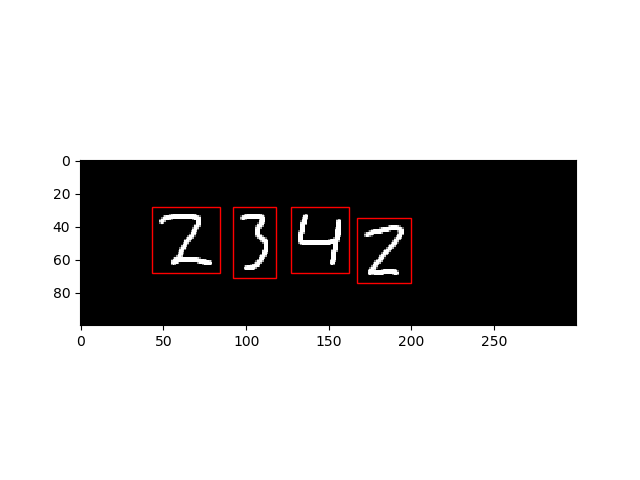

In [285]:
fig, ax = plt.subplots()

img = plt.imread("test2.png")

boxes, labeled_img = get_object_boxes(img, padding=5)

for box in boxes:
    x, y, w, h = box
    ax.add_patch(patches.Rectangle((y,x),h,w,linewidth=1,edgecolor="r",facecolor="none"))

ax.imshow(img)

<IPython.core.display.Javascript object>


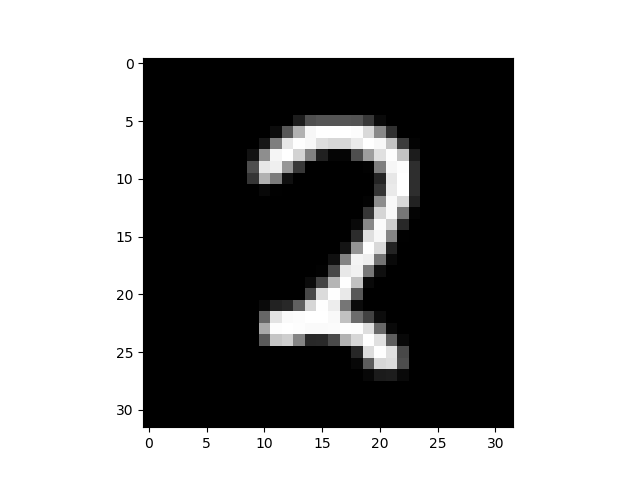

C:\Users\cooli\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


In [172]:
fig, ax = plt.subplots()

regions = get_boxed_regions(img, padding=5)
ax.imshow(regions[1])

## Convolutional MNIST Model

In [166]:
from datasets import load_mnist, download_mnist
from mynn.initializers.glorot_uniform import glorot_uniform
from mynn.layers.conv import conv
from mynn.layers.dense import dense
from mygrad.nnet.layers import max_pool
from mynn.activations.relu import relu
from mynn.losses.cross_entropy import softmax_cross_entropy
import mygrad as mg
import liveplot

In [155]:
download_mnist()
x_train, y_train, x_test, y_test = load_mnist()

#scale down the training and testing data between 0 and 1 where 0 is white and 1 is black
#figure out the range of values currently in your data you know what scaling factor to use
#make sure that the data remains of type np.float32
#this is a form of precprocessing that involves transforming our raw data into an understandable format
x_train = np.pad(x_train, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")
x_test = np.pad(x_test, ((0, 0), (0, 0), (2, 2), (2, 2)), mode="constant")

File already exists:
	C:\Users\cooli\datasets\mnist.npz
mnist loaded


In [156]:
x_train = x_train.astype(float)
x_test = x_test.astype(float)

x_train /= 255.0
x_test /= 255.0

In [235]:
class Model(object):
    ''' A simple convolutional neural network used for MNIST classification. '''
    def __init__(self):
        self.conv1 = conv(1, 20, (5,5), stride=(1,1), weight_initializer=glorot_uniform)
        self.conv2 = conv(20, 10, (5,5), stride=(1,1), weight_initializer=glorot_uniform)

        self.dense1 = dense(250, 100, weight_initializer=glorot_uniform)
        self.dense2 = dense(100, 10, weight_initializer=glorot_uniform)
        
    def __call__(self, x):
        ''' Defines a forward pass of the model.
        
        Parameters
        ----------
        x : numpy.ndarray, shape=(N, 1, 32, 32)
            The input data, where N is the number of images.
            
        Returns
        -------
        mygrad.Tensor, shape=(N, 10)
            The class scores for each of the N images.
        '''
        
        x = max_pool(self.conv1(x),(2,2),(2,2))
        x = max_pool(self.conv2(x),(2,2),(2,2))
        x = x.reshape(x.shape[0], -1)
        x = relu(self.dense1(x))
        x = self.dense2(x)
        
        return x
    
    @property
    def parameters(self):
        ''' A convenience function for getting all the parameters of our model. '''
        return self.dense1.parameters + self.dense2.parameters + self.conv1.parameters + self.conv2.parameters

In [163]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(M, D)
        The scores for D classes, for a batch of M data points
    truth : numpy.ndarray, shape=(M,)
        The true labels for each datum in the batch: each label is an
        integer in [0, D)
    
    Returns
    -------
    float
    """
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

<IPython.core.display.Javascript object>


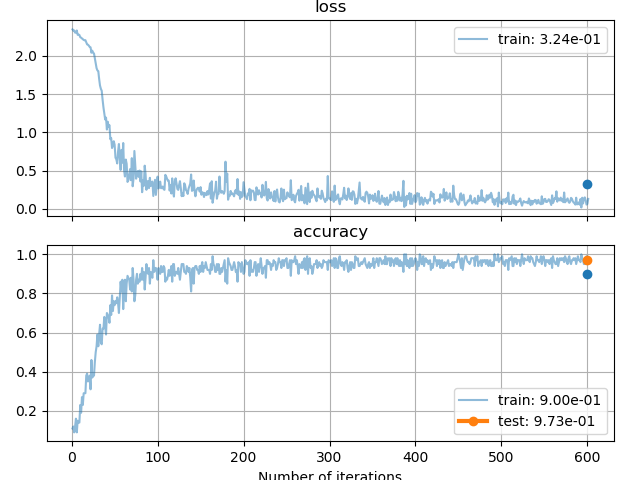

In [236]:
plotter, fig, ax = liveplot.create_plot(metrics=["loss", "accuracy"], refresh=2.5)

from mynn.optimizers.sgd import SGD

model = Model()
optim = SGD(model.parameters, learning_rate=0.01, momentum=0.9, weight_decay=5e-4)

In [238]:
batch_size = 100

# We will train for ~10 epochs; you can change this if you'd like
for epoch_cnt in range(1):
    idxs = np.arange(len(x_train))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)  
    
    
    for batch_cnt in range(0, len(x_train)//batch_size):
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_train[batch_indices]  # random batch of our training data

        # compute the predictions for this batch by calling on model
        y_pred = model(batch)
        # compute the true (a.k.a desired) values for this batch: 
        y_true = y_train[batch_indices]
        # compute the loss associated with our predictions(use softmax_cross_entropy)
        loss = softmax_cross_entropy(y_pred, y_true)
        acc = accuracy(y_pred, y_true)
        # back-propagate through your computational graph through your loss
        loss.backward()
        # execute gradient descent by calling step() of `optim`
        optim.step()
        # null your gradients (please!)
        loss.null_gradients()
        
        # set the training loss and accuracy
        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that 
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(x_test)//batch_size):
        idxs = np.arange(len(x_test))
        batch_indices = idxs[batch_cnt*batch_size : (batch_cnt + 1)*batch_size]
        batch = x_test[batch_indices] 
        
        # get your model's prediction on the test-batch
        y_pred = model(batch)
        # get the truth values for that test-batch
        y_true = y_test[batch_indices]
        # compute the test accuracy
        acc = accuracy(y_pred, y_true)

        # DO NOT back-prop or do gradient descent!
        
        # log the test-accuracy in liveplot for each-
        plotter.set_test_batch({ "accuracy" : acc},
                                 batch_size=batch_size)
    # this tells liveplot to plot the epoch-level train/test statistics :)
    plotter.plot_train_epoch()
    plotter.plot_test_epoch()

KeyboardInterrupt: 

## Applying model to multi-digit recognition

In [270]:
def recognize_number(fpath):
    """ Reads a number left to right from a given file.
    
        Parameters
        ----------
            fpath : string
                File path to read image from.
                
        Returns
        -------
            total : int
                Final expected number in the image.
    
    """
    img = plt.imread(fpath)
    regions, x_coords = get_boxed_regions(img, padding=5)
    
    regions = regions[np.argsort(x_coords)]
    
    total = 0
    
    for region in regions:
        region_batch = np.mean(region, axis=2).reshape(1,1,32,32)
        digit = np.argmax(model(region_batch))
        
        total *= 10
        total += digit
    
    return total

In [283]:
recognize_number("test_number.png")

C:\Users\cooli\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


2342

<IPython.core.display.Javascript object>


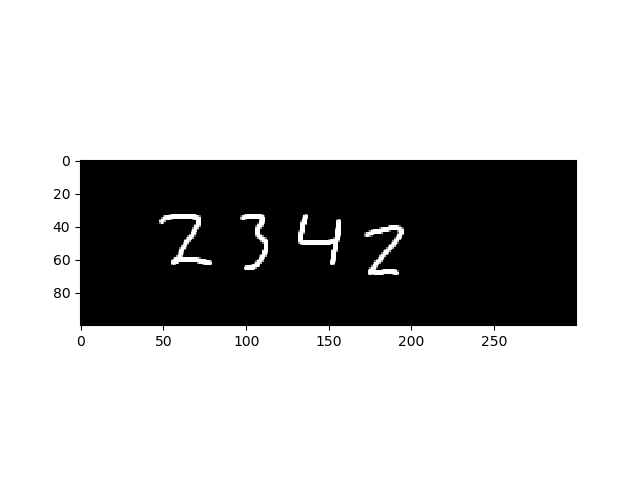

C:\Users\cooli\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


In [284]:
fig, ax = plt.subplots()
ax.imshow(ndimage.imread("test_number.png"))